In [26]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
from scipy import stats # Статистикa
from tqdm.notebook import tqdm
%matplotlib inline

In [16]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230520'
}

In [17]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-24' and '2023-04-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [18]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


In [19]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


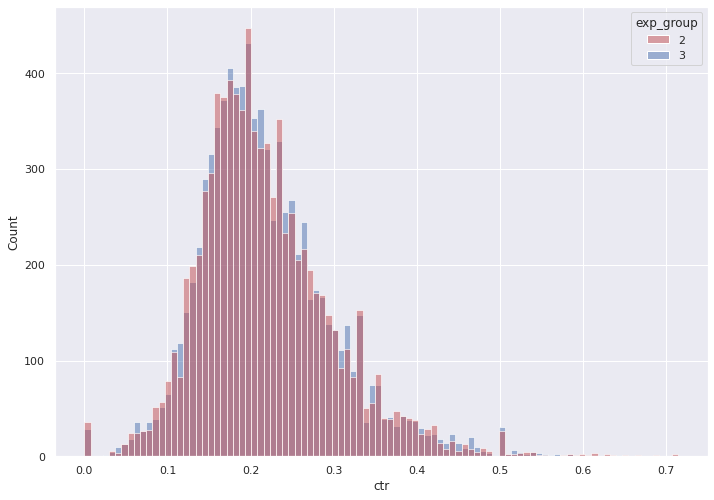

In [99]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [24]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [121]:
pval = []
for _ in range(10000):
    pval.append(stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500, replace = False),
                df[df.exp_group == 3].ctr.sample(500, replace = False),
                equal_var=False)[1])

In [135]:
pval[:5]

,pval
0,0.171673
1,0.152986
2,0.321630
3,0.610181
4,0.878094


<AxesSubplot:ylabel='Count'>

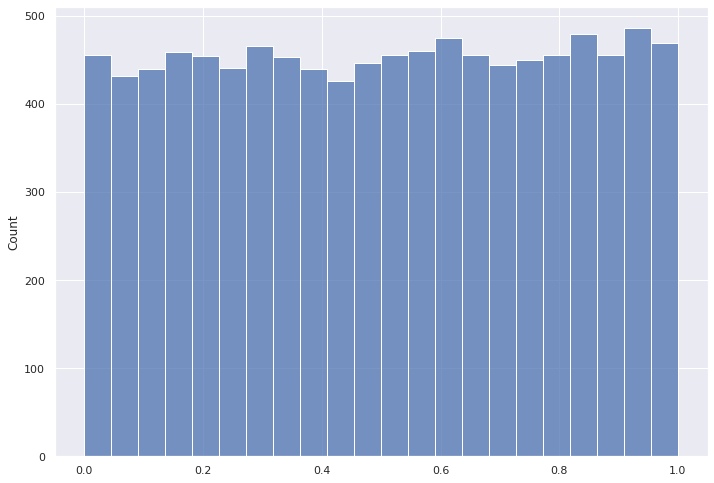

In [123]:
sns.histplot(pval)

In [124]:
pval = pd.DataFrame(pval, columns = ['pval'])
pval

,pval
0,0.171673
1,0.152986
2,0.321630
3,0.610181
4,0.878094
...,...
9995,0.666301
9996,0.934358
9997,0.151776
9998,0.487639


In [152]:
(pval[pval['pval'] <= 0.05].count() / len(pval))[0]

0.0496

# Вывод

#### Посмотрел на кол-во пользователей в группах 2 и 3. Затем на распределение CTR'а двух выборок, Визуально сходится.
#### Сформировав 10000 раз p-value  с помощью t-теста, посмотрел на распределение p-value. Распределение примерно равномерное. 
#### Из 10000 (p-value < 0.05) < 5%, значит все хорошо. 5% - допустимая погрешность